In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import tensorflow as tf
from scipy.stats import linregress
import matplotlib as mpl
# Useful helper function
#r_squared = lambda x,y: linregress(x.ravel().T, y.ravel().T)[2]**2
#%config InlineBackend.figure_format = 'retina'
from scipy.stats import pearsonr
#import pingouin

# Insert mavenn at beginning of path
import sys
path_to_mavenn_local = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh/'
sys.path.insert(0, path_to_mavenn_local)

#Load mavenn and check path
import mavenn
print(mavenn.__path__)

['/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh/mavenn']


In [2]:
# load subsampled models 
subsampled_models = {}

for subsampled_double_mutants in ['500','5000','50000']:
    subsampled_models[subsampled_double_mutants] =  mavenn.load(f'21.12.28.gb1_subsampled_models/gb1_ge_additive_subsampled_N_{subsampled_double_mutants}')


Model loaded from these files:
	21.12.28.gb1_subsampled_models/gb1_ge_additive_subsampled_N_500.pickle
	21.12.28.gb1_subsampled_models/gb1_ge_additive_subsampled_N_500.h5
Model loaded from these files:
	21.12.28.gb1_subsampled_models/gb1_ge_additive_subsampled_N_5000.pickle
	21.12.28.gb1_subsampled_models/gb1_ge_additive_subsampled_N_5000.h5
Model loaded from these files:
	21.12.28.gb1_subsampled_models/gb1_ge_additive_subsampled_N_50000.pickle
	21.12.28.gb1_subsampled_models/gb1_ge_additive_subsampled_N_50000.h5


In [3]:
gb1_additive_full_model = mavenn.load('21.12.28.gb1_full_model/gb1_additive_ge_2021.12.28.12h.48m')

Model loaded from these files:
	21.12.28.gb1_full_model/gb1_additive_ge_2021.12.28.12h.48m.pickle
	21.12.28.gb1_full_model/gb1_additive_ge_2021.12.28.12h.48m.h5


In [4]:
np.random.seed(0)

# Load example data 
data_df = mavenn.load_example_dataset('gb1')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 26,364
training + validation N: 504,373


,set,dist,input_ct,selected_ct,y,x
0,training,2,173,33,-3.145154,AAKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,training,2,18,8,-1.867676,ACKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,training,2,66,2,-5.270800,ADKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,training,2,72,1,-5.979498,AEKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,training,2,69,168,0.481923,AFKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
5,training,2,108,1,-6.557858,AGKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
6,training,2,48,93,0.150206,AHKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
7,training,2,119,49,-2.052708,AIKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
8,training,2,252,79,-2.450739,ALKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
9,training,2,110,116,-0.713724,AMKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [5]:
# Subsample indices for easy plotting and information estimation (select 5000 test points for plotting)
N_test = len(test_df)
ix = np.random.rand(N_test) < .1841

# Get x and y
x_test = test_df['x'].values[ix]
y_test = test_df['y'].values[ix]

len(x_test)

5000

In [6]:
# Write function to compute bootstrap resampled uncertainties in correlation coefficient.
def my_rsquared(x,y, bootstrap_samples=100):
    """Returns R^2 and SE thereof based on bootstrap resampling"""
    r2 = pearsonr(x,y)[0]**2 # pingouin.corr(x, y).loc['pearson','r']**2
    N = len(x)
    assert len(x)==len(y), f'len(x)={len(x)} and len(y)={len(y)} are not the same.'
    r2s = np.zeros(bootstrap_samples)
    for i in range(bootstrap_samples):
        ix = np.random.choice(a=bootstrap_samples, size=bootstrap_samples, replace=True)
        r2s[i] = pearsonr(x[ix],y[ix])[0]**2 #pingouin.corr(x[ix], y[ix]).loc['pearson','r']**2
    dr2 = np.std(r2s)
    return r2, dr2

In [7]:
style_file_name = 'fig3.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [8]:
from matplotlib.colors import TwoSlopeNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

def heatmap(values,
            alphabet,
            seq=None,
            seq_kwargs=None,
            ax=None,
            show_spines=False,
            cbar=True,
            cax=None,
            clim=None,
            clim_quantile=1,
            ccenter=None,
            cmap='coolwarm',
            cmap_size="5%",
            cmap_pad=0.1,
            first_pos=1):
    """
    Draw a heatmap illustrating an ``L`` x ``C`` matrix of values, where ``L`` is
    sequence length and ``C`` is the alphabet size.

    Parameters
    ----------
    values: (np.ndarray)
        Array of shape ``(L,C)`` that contains values to plot.

    alphabet: (str, np.ndarray)
        Alphabet name ``'dna'``, ``'rna'``, or ``'protein'``, or 1D array
        containing characters in the alphabet.

    seq: (str, None)
        The sequence to show, if any, using dots plotted on top of the heatmap.
        Must have length ``L`` and be comprised of characters in ``alphabet``.

    seq_kwargs: (dict)
        Arguments to pass to ``Axes.scatter()`` when drawing dots to illustrate
        the characters in ``seq``.

    ax: (matplotlib.axes.Axes)
        The ``Axes`` object on which the heatmap will be drawn.
        If ``None``, one will be created. If specified, ``cbar=True``,
        and ``cax=None``, ``ax`` will be split in two to make room for a
        colorbar.

    show_spines: (bool)
        Whether to show spines around the edges of the heatmap.

    cbar: (bool)
        Whether to draw a colorbar next to the heatmap.

    cax: (matplotlib.axes.Axes, None)
        The ``Axes`` object on which the colorbar will be drawn,
        if requested. If ``None``, one will be created by splitting
        ``ax`` in two according to ``cmap_size`` and ``cmap_pad``.

    clim: (list, None)
        List of the form ``[cmin, cmax]``, specifying the maximum ``cmax``
        and minimum ``cmin`` values spanned by the colormap. Overrides
        ``clim_quantile``.

    clim_quantile: (float)
        Must be a float in the range [0,1]. ``clim`` will be automatically
        chosen to include this central quantile of values.

    ccenter: (float)
        Value at which to position the center of a diverging
        colormap. Setting ``ccenter=0`` often makes sense.

    cmap: (str, matplotlib.colors.Colormap)
        Colormap to use.

    cmap_size: (str)
        Fraction of ``ax`` width to be used for the colorbar. For formatting
        requirements, see the documentation for
        ``mpl_toolkits.axes_grid1.make_axes_locatable()``.

    cmap_pad: (float)
        Space between colorbar and the shrunken heatmap ``Axes``. For formatting
        requirements, see the documentation for
        ``mpl_toolkits.axes_grid1.make_axes_locatable()``.
        
    first_pos: (int)
        Value of first position. 

    Returns
    -------
    ax: (matplotlib.axes.Axes)
        ``Axes`` object containing the heatmap.

    cb: (matplotlib.colorbar.Colorbar, None)
        Colorbar object linked to ``ax``, or ``None`` if no colorbar was drawn.
    """
    #alphabet = validate_alphabet(alphabet)
    L, C = values.shape

    # Set extent
    #xlim = [-.5, L - .5]
    xlim = [first_pos - .5, L + first_pos - .5]
    ylim = [-.5, C - .5]

    # If wt_seq is set, validate it.
    #if seq:
    #    seq = validate_seqs(seq, alphabet)

    # Set color lims to central 95% quantile
    if clim is None:
        vals = values.ravel()
        vals = vals[np.isfinite(vals)]
        clim = np.quantile(vals, q=[(1 - clim_quantile) / 2,
                                    1 - (1 - clim_quantile) / 2])

    # Create axis if none already exists
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # Needed to center colormap at zero
    if ccenter is not None:

        # Reset ccenter if is not compatible with clim
        if (clim[0] > ccenter) or (clim[1] < ccenter):
            ccenter = 0.5 * (clim[0] + clim[1])

        norm = TwoSlopeNorm(vmin=clim[0], vcenter=ccenter, vmax=clim[1])

    # Otherwise, use uncentered colormap
    else:
        norm = Normalize(vmin=clim[0], vmax=clim[1])

    # Plot heatmap
    #x_edges = np.arange(L + 1) - .5
    x_edges = np.arange(L + 1) + first_pos - 0.5
    y_edges = np.arange(C + 1) - .5
    im = ax.pcolormesh(x_edges,
                       y_edges,
                       values.T,
                       shading='flat',
                       cmap=cmap,
                       clim=clim,
                       norm=norm)

    # Mark wt sequence
    _ = np.newaxis
    if seq:
        
        seq = [seq]
        # Set marker style
        if seq_kwargs is None:
            seq_kwargs = {'marker': '.', 'color': 'k', 's': 2}

        # Get xy coords to plot
        seq_arr = np.array(list(seq[0]))
        xy = np.argwhere(seq_arr[:, _] == alphabet[_, :])

        # Mark sequence
        ax.scatter(xy[:, 0] + first_pos, xy[:, 1], **seq_kwargs)
        #pdb.set_trace()

    # Style plot
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_yticks(range(C))
    ax.set_yticklabels(alphabet, ha='center')
    ax.invert_yaxis()

    if not show_spines:
        for loc, spine in ax.spines.items():
            spine.set_visible(False)

    # Create colorbar if requested, make one
    if cbar:
        if cax is None:
            cax = make_axes_locatable(ax).new_horizontal(size=cmap_size,
                                                         pad=cmap_pad)
            fig.add_axes(cax)
        cb = plt.colorbar(im, cax=cax)

        # Otherwise, return None for cb
    else:
        cb = None

    return ax, cb

In [9]:
# Get indices for aa order used in Olson et al.
ordered_aa = np.array(list('EDRKHQNSTPGCAVILMFYW'))
ix = ordered_aa.argsort()
sorted_aa = ordered_aa[ix]
ixx = ix.argsort()
sorted_aa[ixx]

array(['E', 'D', 'R', 'K', 'H', 'Q', 'N', 'S', 'T', 'P', 'G', 'C', 'A',
       'V', 'I', 'L', 'M', 'F', 'Y', 'W'], dtype='<U1')

In [10]:
# FULL MODEL VARIABLES

theta = gb1_additive_full_model.get_theta()['theta_lc']
alphabet = gb1_additive_full_model.alphabet
seq = gb1_additive_full_model.x_stats['consensus_seq']

phi_b = gb1_additive_full_model.x_to_phi(x_test)
yhat_test_b = gb1_additive_full_model.phi_to_yhat(phi_b)

phi_lim = [-5, 2.5]
phi_grid_b = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid_b = gb1_additive_full_model.phi_to_yhat(phi_grid_b)
yq_grid_b = gb1_additive_full_model.yhat_to_yq(yhat_grid_b, q=[.16,.84])

phi_wt_full = gb1_additive_full_model.x_to_phi([gb1_additive_full_model.x_stats['consensus_seq']])

yhat_c = yhat_test_b

yhat_wt_full = gb1_additive_full_model.x_to_yhat([gb1_additive_full_model.x_stats['consensus_seq']])

train_I_var_d = gb1_additive_full_model.history['I_var']

# these numbers need to recomputed but I don't have intrinsic info value. Using previously reported value
I_bb = 2.68058934
I_intr = 3.2127

I_var, dI_var =  gb1_additive_full_model.I_variational(x=x_test, y=y_test)
I_pred, dI_pred = gb1_additive_full_model.I_predictive(x=x_test, y=y_test)

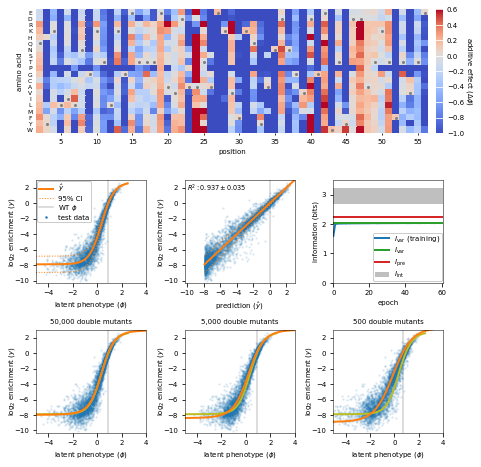

In [11]:
fig = plt.figure(figsize=[6.69291, 6.5])
gs = fig.add_gridspec(3, 3, height_ratios=[1.2,1,1])

# Set lims and ticks
ylim = [-10.3, 3] 
yticks = [-10,-8,-6,-4,-2,0,2]
phi_lim = [-5,4]
phi_ticks = [-4,-2,0,2,4]
I_lim = [0, 3.5]
I_ticks = [0,1,2,3]

# Define panels
ax_a = fig.add_subplot(gs[0, :])
ax_b = fig.add_subplot(gs[1, 0])
ax_c = fig.add_subplot(gs[1, 1])
ax_d = fig.add_subplot(gs[1, 2])
ax_e = fig.add_subplot(gs[2, 0])
ax_f = fig.add_subplot(gs[2, 1])
ax_g = fig.add_subplot(gs[2, 2])

# Panel A: Heatmap
ax = ax_a
ax, cb = heatmap(theta[:,ixx], 
                 alphabet[ixx],
                 ax=ax, 
                 seq=seq, 
                 seq_kwargs={'s':4, 'color':'gray'},
                 ccenter=0,
                 clim=[-1,.6],
                 cmap_size="2%",
                 cmap='coolwarm',
                 first_pos=2)
ax.set_ylabel('amino acid')
ax.set_xlabel('position')
ax.set_xticks(range(5,60,5))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(rotation=0, size=2)
ax.tick_params(axis='y', size=0, pad=6, labelsize=6)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=10, color='white')
cb.set_ticks([-1.0,-0.8,-.6, -.4, -.2, 0, .2, .4, .6])
cb.set_label('additive effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Panel B: GE plot
#N_plot = 5000
#ix = np.random.choice(len(y_test_a), size=N_plot, replace=False)
ax = ax_b
ax.scatter(phi_b, 
           y_test, 
           s=2,
           alpha=.1,
           label='test data',
           color='C0')

ax.set_xticks(phi_ticks)
ax.set_yticks(yticks)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('$\log_2$ enrichment ($y$)', labelpad=-3)
ax.set_xlim(phi_lim)
ax.set_ylim(ylim)

ax.plot(phi_grid_b, yhat_grid_b,    color='C1', alpha=1, linewidth=2, linestyle='-', label='$\hat{y}$')
ax.plot(phi_grid_b, yq_grid_b[:,0], color='C1', linestyle=':', linewidth=1,  label='95% CI')
ax.plot(phi_grid_b, yq_grid_b[:,1], color='C1', linestyle=':', linewidth=1)

# draw wt phi
ax.axvline(phi_wt_full, color='lightgray', zorder=-1, label='WT $\phi$')

# ax.legend()
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# # Panel C: Scatter plot
ax = ax_c
xlim = [min(yhat_c), ylim[1]]
ax.scatter(yhat_c, 
           y_test, 
           s=2,
           label='test data',
           alpha=.1,
           color='C0')
ax.set_xticks(yticks)
ax.set_yticks(yticks)
ax.set_xlabel('prediction ($\hat{y}$)')
ax.set_ylabel('$\log_2$ enrichment ($y$)', labelpad=-3)
ax.set_xlim(ylim)
ax.set_ylim(ylim)
ax.plot(xlim, xlim, linestyle='-', color='C1', linewidth=2, label='$\hat{y}$')
ax.plot(yhat_grid_b, yq_grid_b[:,0], linestyle=':', color='C1', linewidth=1, label='95% CI')
ax.plot(yhat_grid_b, yq_grid_b[:,1], linestyle=':', color='C1', linewidth=1)

# draw wt phi
ax.axvline(yhat_wt_full, color='lightgray', zorder=-1)

# # Compute R^2
r2, dr2 = my_rsquared(yhat_c, y_test)
ax.text(x=-10, y=2, s=f'$R^2: {r2:.3f} \pm {dr2:.3f}$', ha='left', va='center', fontsize=6.5)

# Panel D: Training plot
ax = ax_d

epochs = np.arange(len(train_I_var_d))
xlim = [0, max(epochs)]

ax.plot(epochs, train_I_var_d, '-', label='$I_\mathrm{var}$ (training)', color='C0', linewidth=2)

# Draw information lines
I_intr = 3.2127 
dI_intr = 0.0168
ax.axhline(I_var,  label='$I_\mathrm{{var}}$', color='C2', linestyle='-', linewidth=2, alpha=1)
ax.axhline(I_pred, label='$I_\mathrm{{pre}}$', color='C3', linestyle='-', linewidth=2, alpha=1)
ax.fill_between(xlim, [I_bb, I_bb], [I_intr, I_intr], linewidth=0,
                color='gray', alpha=.5, zorder=-100, label='$I_\mathrm{int}$')

ax.set_ylim(I_lim)
ax.set_yticks(I_ticks)
ax.set_xlim([0, max(epochs)])
ax.set_xlabel('epoch')
ax.set_ylabel('information (bits)', labelpad=3)
ax.legend(loc='lower right')


for model_index, model_s in enumerate(['50000','5000','500']):
    if model_index == 0:
        ax = ax_e
        double_mutants = '50,000'
    elif model_index == 1:
        double_mutants = '5,000'        
        ax = ax_f
    elif model_index == 2:
        double_mutants = '500'        
        ax = ax_g
    model = subsampled_models[model_s]
    phi = model.x_to_phi(x_test)
    yhat= model.x_to_yhat(x_test)
    
    phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
    yhat_grid = model.phi_to_yhat(phi_grid)
    yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

    # Create grid for plotting yhat and yqs
    #phi_lim = [-5, 2.5]
    #ax = axs[model_index]
    # Illustrate measurement process with GE curve
    ax.scatter(phi, y_test, color='C0', s=2, alpha=.1, label='data (sub)')
    ax.plot(phi_grid_b, yhat_grid_b, linewidth=2, color='C8', label='$\hat{y}$ (full)')
    ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
            label='$\hat{y}$ (sub)')
    #ax.plot(phi_grid, yqs_grid[:, 0], linestyle=':', color='C3',
    #        label='95% CI')
    #ax.plot(phi_grid, yqs_grid[:, 1], linestyle=':', color='C3')
    ax.set_xlim(phi_lim)
    ax.set_xlabel('latent phenotype ($\phi$)')
    ax.set_ylabel('$\log_2$ enrichment ($y$)', labelpad=-3)
    ax.set_title(f'{double_mutants} double mutants',fontsize=7)
    #ax.legend()
    ax.set_xticks(phi_ticks)
    ax.set_yticks(yticks)
    ax.set_ylim(ylim)
    
    # draw wt phi
    phi_wt_sub = model.x_to_phi([gb1_additive_full_model.x_stats['consensus_seq']])
    ax.axvline(phi_wt_sub, color='lightgray', zorder=-1, label='WT $\phi$ (sub)')
    
    if model_s==0:      
        leg = ax.legend(loc='upper left')
        for lh in leg.legendHandles: 
            lh.set_alpha(1)

# # Clean up and save
fig.tight_layout()
fig.savefig('fig3_ipynb.png', dpi=400, facecolor='w')
# #fig.savefig('fig3_ipynb.pdf', dpi=400, facecolor='w')